In [1]:
%matplotlib inline

In [2]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal, ndimage, misc
import pywt
from keras.datasets import mnist
from keras.utils import np_utils



Using TensorFlow backend.


In [3]:
from matplotlib.pyplot import imshow
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
def nimshow(img):
    plt.imshow(img, interpolation='none')
    
def conv(img, kern, renorm=False):
    ift = signal.fftconvolve(img, kern, 'same')
    if renorm:
        ift /= np.amax(ift)
    return ift

def ricker2d(x, y, f=np.pi, n=0.5):
    r = (x**2 + y**2)**n
    return (1.0 - 2.0*(np.pi**2)*(f**2)*(r**2)) * np.exp(-(np.pi**2)*(f**2)*(r**2))

def gauss2d(x, y, f=1, sig=1, n=0.5):
    r = (x**2 + y**2)**n
    return np.exp(-((f*r)**2)/(.25*sig**2))

In [5]:
def plot_3d(image, threshold=-300, azim=45, elev=45):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
#     p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.azim = azim
    ax.elev = elev

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
def splay(volume, rows=5, cols=5, figsize=(10, 10), cmap=None, interpolation=None):
    fig = plt.figure(figsize=figsize)
    n = rows*cols
    for i in range(rows):
        for j in range(cols):
            fig.add_subplot(rows, cols, cols*i+j+1)
            try:
                v = volume[cols*i+j]
                plt.imshow(v, cmap=cmap, interpolation=interpolation)
            except IndexError:
                pass



In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
# x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))
y_train_oh = np_utils.to_categorical(y_train)
y_test_oh = np_utils.to_categorical(y_test)
x_train3d = np.load('x_train_mnist3d_1k.npy')
print(x_train3d.shape)
y_train_oh = y_train_oh[:len(x_train3d)]

(1000, 28, 28, 28)


In [7]:
ratio = 32/28
x_train3d_2x = sp.ndimage.zoom(x_train3d, (1,ratio,ratio,ratio))

(32, 32, 32) 32768


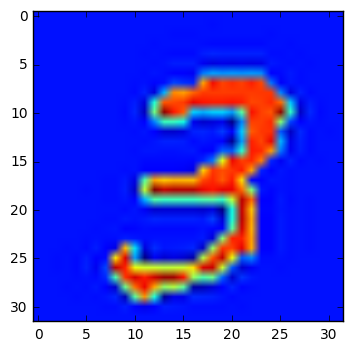

In [8]:
vol = x_train3d_2x[7]
orig_size = np.prod(vol.shape)
print(vol.shape, orig_size)
plt.imshow(vol[13], interpolation=None)# cmap='gray')

In [9]:
wp = pywt.dwtn(vol, 'haar')
v1 = wp['aaa']
newshape = v1.shape
np.prod(vol.shape)
print(newshape, np.product(newshape), orig_size /np.product(newshape))

(16, 16, 16) 4096 8.0


In [10]:
wp.keys()

dict_keys(['dad', 'aaa', 'daa', 'dda', 'ddd', 'ada', 'aad', 'add'])

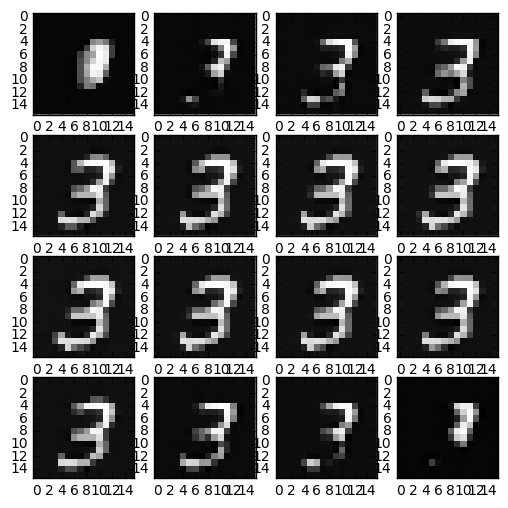

In [11]:
splay(v1, 4, 4, figsize=(6,6), interpolation='none', cmap='gray')

In [12]:
wp2 = pywt.dwtn(wp['aaa'], 'haar')
v2 = wp2['aaa']
newshape = v2.shape
np.prod(vol.shape)
print(newshape, np.product(newshape), orig_size /np.product(newshape))

(8, 8, 8) 512 64.0


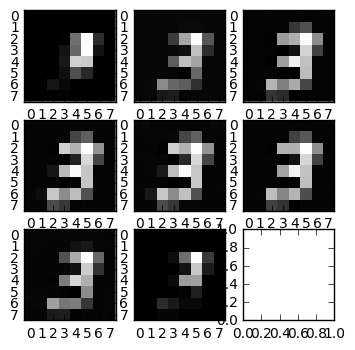

In [13]:
splay(v2, 3, 3, figsize=(4,4), cmap='gray', interpolation='none')

In [14]:
g2 = sp.ndimage.filters.gaussian_filter(v2, .1, order=2)

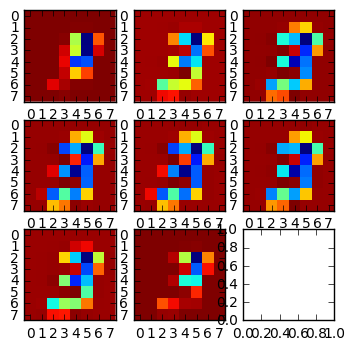

In [15]:
splay(g2, 3, 3, figsize=(4,4), interpolation='none')

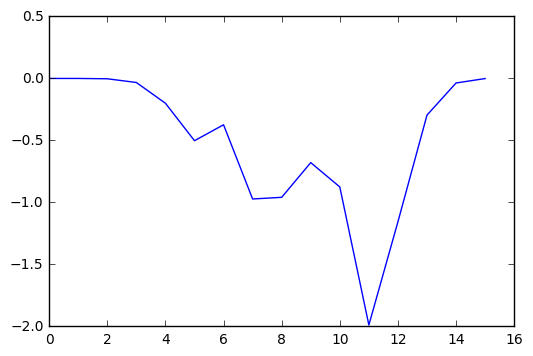

In [16]:
g1 = sp.ndimage.filters.gaussian_filter(v1, 1, order=0)
v1a = v1-2*g1
plt.plot(v1a[len(v1a)//2, len(v1a)//2])

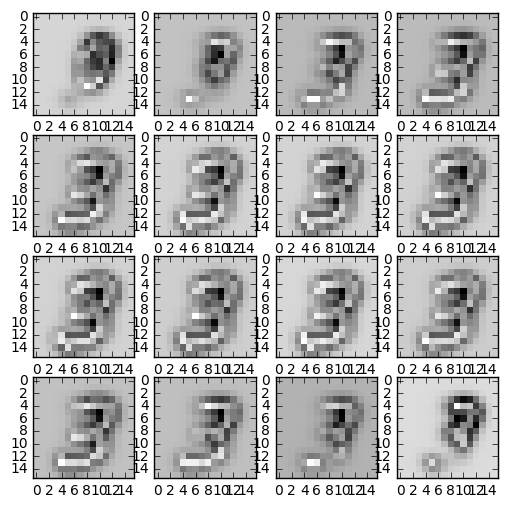

In [17]:
splay(v1a, 4,4, figsize=(6,6), interpolation='none', cmap='gray')